In [117]:
import numpy as np

In [118]:
matplotlib_style = 'fivethirtyeight'

import matplotlib.pyplot as plt; 
import matplotlib.axes as axes;

plt.style.use(matplotlib_style)

%matplotlib inline

In [119]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

# check whether eager execution is enabled
assert tf.executing_eagerly()

In [120]:
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
      `namedtuple` or combinations thereof.
 
    Returns:
      ndarrays: Object with same structure as `tensors` except with `Tensor` or
        `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.is_tensor(t) else t
             for t in tf.nest.flatten(tensors)])
    return sess.run(tensors)

setattr(tf.Tensor, "evl", evaluate)

## Coin-flip example

Every statistics text must contain a coin-flipping example, I'll use it here to get it out of the way. Suppose, naively, that you are unsure about the probability of heads in a coin flip (spoiler alert: it's 50%). You believe there is some true underlying ratio, call it $p$, but have no prior opinion on what $p$ might be.

We begin to flip a coin, and record the observations: either $H$ or $T$. This is our observed data. An interesting question to ask is how our inference changes as we observe more and more data? More specifically, what do our posterior probabilities look like when we have little data, versus when we have lots of data.

In [121]:
coin_flip_dist = tfd.Bernoulli(probs=0.5, dtype=tf.int32)

n_trails = tf.constant([0, 1, 2, 3, 4, 5, 8, 15, 50, 500, 1000, 2000])
data = coin_flip_dist.sample(n_trails[-1] + 1)

# cumsum - returns the cumulative sum of heads as an array
# gather - slice from array according to indices
n_trails_heads_count = tf.gather(tf.cumsum(data), n_trails)

In [122]:
n_trails_heads_count

<tf.Tensor: id=1046095, shape=(12,), dtype=int32, numpy=
array([   1,    2,    2,    2,    3,    4,    5,    7,   25,  251,  503,
       1006])>

In [123]:
# posterior based on observations in each trail
n_posterior = tfd.Beta(
    concentration1=tf.cast(1 + headcounts, tf.float32),
    concentration0=tf.cast(1 + n_trails - headcounts, tf.float32))

In [124]:
x = tf.linspace(start=0., stop=1., num=100, name="linspace")
n_y = tf.transpose(n_posterior.prob(x[:, tf.newaxis]))
n_y

<tf.Tensor: id=1046129, shape=(12, 100), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
               nan],
       [0.        , 0.02020202, 0.04040404, ..., 1.9595959 , 1.979798  ,
               nan],
       [0.        , 0.05999387, 0.11876338, ..., 0.11876352, 0.05999393,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)>

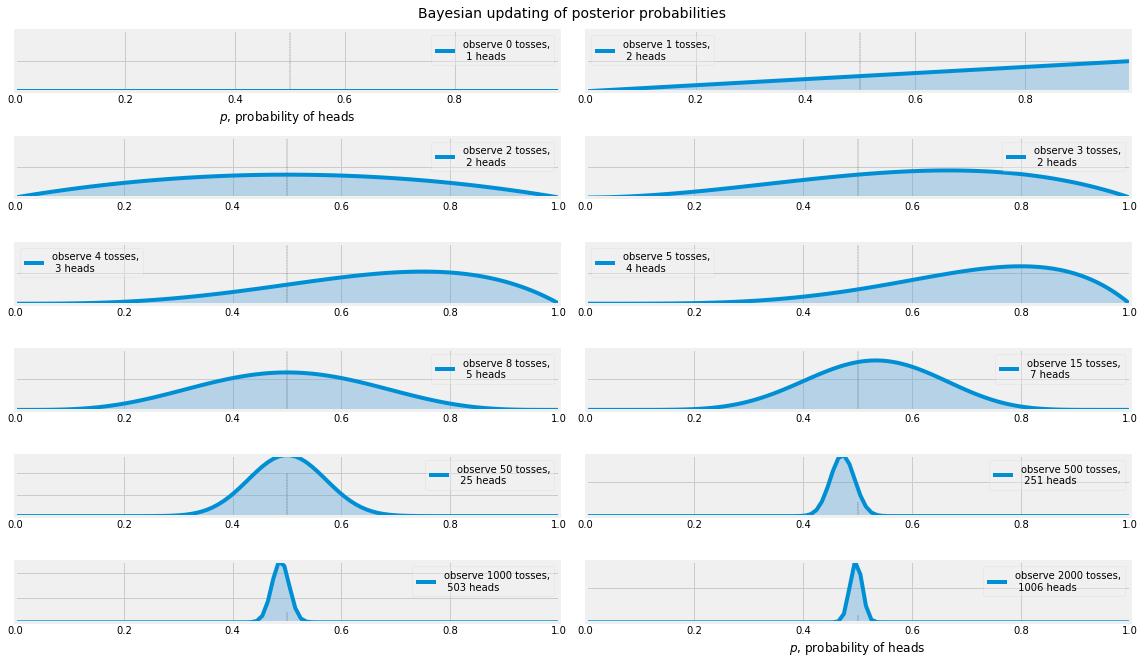

In [125]:
plt.figure(figsize=(16, 9))
for i in range(len(n_trails)):
    sx = plt.subplot(len(n_trails) / 2, 2, i + 1)
    plt.xlabel("$p$, probability of heads") if i in [0, len(n_trails)-1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    
    plt.plot(x, n_y[i], label="observe %d tosses,\n %d heads" % (n_trails[i], n_trails_heads_count[i]))
    plt.fill_between(x, 0, n_y[i], color='#5DA5DA', alpha=0.4)
    
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=0.3)
    
    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)

plt.suptitle("Bayesian updating of posterior probabilities", y=1.02, fontsize=14)
plt.tight_layout()

## Inferring behaviour from text-message data

Given a series of daily text-message counts from a user of your system. The data, plotted over time, appears in the chart below. You are curious to know if the user's text-messaging habits have changed over time, either gradually or suddenly. How can you model this?

In [126]:
count_data = tf.constant([
    13,  24,   8,  24,   7,  35,  14,  11,  15,  11,  22,  22,  11,  57,  
    11,  19,  29,   6,  19,  12,  22,  12,  18,  72,  32,   9,   7,  13,  
    19,  23,  27,  20,   6,  17,  13,  10,  14,   6,  16,  15,   7,   2,  
    15,  15,  19,  70,  49,   7,  53,  22,  21,  31,  19,  11,  18,  20,  
    12,  35,  17,  23,  17,   4,   2,  31,  30,  13,  27,   0,  39,  37,   
    5,  14,  13,  22,
], dtype=tf.float32)
n_count_data = tf.shape(count_data)
days = tf.range(n_count_data[0])

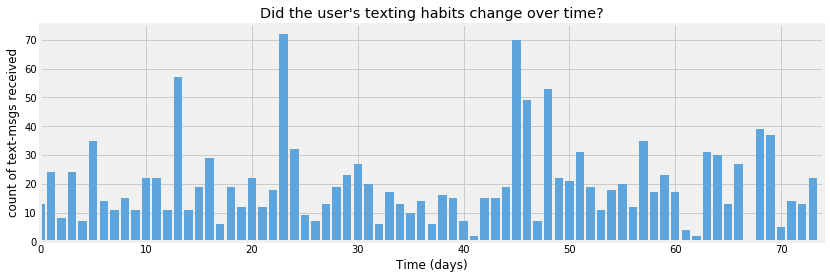

In [127]:
plt.figure(figsize=(12.5, 4))
plt.bar(days.evl(), count_data.evl(), color="#5DA5DA")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data[0].evl());

$$P(A|X) = \frac {P(X|A)P(A)} {P(X)} \propto P(X|A)P(A)$$

In [128]:
def joint_log_prob(count_data, lambda_1, lambda_2, tau):
    tfd = tfp.distributions
 
    alpha = np.array(1. / count_data.mean(), np.float32)
    prior_lambda_1 = tfd.Exponential(rate=alpha)
    prior_lambda_2 = tfd.Exponential(rate=alpha)
 
    prio_tau = tfd.Uniform()
 
    # [0,tau] - l1, (tau, size] - l2
    lambda_ = tf.gather(
         [lambda_1, lambda_2],
         indices=tf.cast(tau * count_data.size <= np.arange(count_data.size), dtype=tf.int32))
    likelihood = tfd.Poisson(rate=lambda_)
 
    return (
         prior_lambda_1.log_prob(lambda_1)
         + prior_lambda_2.log_prob(lambda_2)
         + prio_tau.log_prob(tau)
         + tf.reduce_sum(likelihood.log_prob(count_data))
    )

In [129]:
joint_log_prob(count_data.evl(), 1.0, 2.0, 0.5)

<tf.Tensor: id=1047360, shape=(), dtype=float32, numpy=-2981.0962>

### Poserior sampler

In [130]:
# Set the chain's start state.
initial_chain_state = [
    tf.cast(tf.reduce_mean(count_data), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda1"),
    tf.cast(tf.reduce_mean(count_data), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda2"),
    0.5 * tf.ones([], dtype=tf.float32, name="init_tau"),
]


In [131]:
# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Sigmoid(),   # Maps [0,1] to R.  
]


In [132]:
# Define a closure over our joint_log_prob.
def unnormalized_log_posterior(lambda1, lambda2, tau):
    return joint_log_prob(count_data.evl(), lambda1, lambda2, tau)

In [133]:
# Initialize the step_size. (It will be automatically adapted.)
step_size = tf.Variable(
    name='step_size',
    initial_value=tf.constant(0.05, dtype=tf.float32),
    trainable=False
)

# Sample from the chain.
[
    lambda_1_samples,
    lambda_2_samples,
    posterior_tau,
], kernel_results = tfp.mcmc.sample_chain(
    num_results=1000,
    num_burnin_steps=100,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_log_posterior,
            num_leapfrog_steps=2,
            step_size=step_size,
            step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(num_adaptation_steps=int(100 * 0.8)),
            state_gradients_are_stopped=True),
        bijector=unconstraining_bijectors))

tau_samples = tf.floor(posterior_tau * tf.cast(tf.size(count_data)), tf.float32)

# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tf.shape(tau_samples)[0]
expected_texts_per_day = tf.zeros(n_count_data)


# Initialize any created variables.
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()

KeyboardInterrupt: 

In [ ]:
lambda_1_samples.evl()
